# Proyecto Final: Consumo de Alcohol en Estudiantes


Grupo: 5AM1

Equipo:
*   Gómez Molina Isaac Emiliano
*   Zhang Tan Rubi

Este proyecto analiza la relación entre el consumo de alcohol y el rendimiento académico de estudiantes de la asignatura de Portugués.

# Análisis inicial del dataset

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

In [39]:
df = pd.read_csv('student-por.csv', sep=',')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [40]:
print(df.shape)
print(f"Total de estudiantes: {len(df)}")
print(f"Total de variables: {len(df.columns)}")
print(f"\nINFORMACIÓN GENERAL")
print(df.info())

(649, 33)
Total de estudiantes: 649
Total de variables: 33

INFORMACIÓN GENERAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities

El conjunto de datos contiene variables categóricas y numéricas relacionadas con el contexto familiar, hábitos de estudio, consumo de alcohol y desempeño académico.

In [41]:
print(f"VALORES FALTANTES")

val_faltantes = df.isnull().sum()
if val_faltantes.sum() == 0:
    print("No hay valores faltantes en el dataset")
else:
    print(val_faltantes[val_faltantes > 0])

VALORES FALTANTES
No hay valores faltantes en el dataset


In [42]:
print(f"DETECCIÓN DE OUTLIERS")

def detectar_outliers(df, columna):
    media = df[columna].mean()
    desv_est = df[columna].std()
    lim_inferior = media - 2*desv_est
    lim_superior = media + 2*desv_est
    outliers = df[(df[columna] < lim_inferior) | (df[columna] > lim_superior)]

    return {
        'media': media,
        'desv_est': desv_est,
        'lim_inferior': lim_inferior,
        'lim_superior': lim_superior,
        'n_outliers': len(outliers),
        'pct_outliers': (len(outliers) / len(df)) * 100,
        'outlier_indices': outliers.index.tolist()
    }

variables_continuas = ['age', 'absences', 'G1', 'G2', 'G3', 'studytime', 'failures', 'Dalc', 'Walc']

outliers_info = {}
for col in variables_continuas:
    outliers_info[col] = detectar_outliers(df, col)
    info = outliers_info[col]

    print(f"\n {col}:")
    print(f"   μ = {info['media']:.2f}, σ = {info['desv_est']:.2f}")
    print(f"   Rango normal: [{info['lim_inferior']:.2f}, {info['lim_superior']:.2f}]")
    print(f"   Outliers: {info['n_outliers']} ({info['pct_outliers']:.2f}%)")

DETECCIÓN DE OUTLIERS

 age:
   μ = 16.74, σ = 1.22
   Rango normal: [14.31, 19.18]
   Outliers: 9 (1.39%)

 absences:
   μ = 3.66, σ = 4.64
   Rango normal: [-5.62, 12.94]
   Outliers: 32 (4.93%)

 G1:
   μ = 11.40, σ = 2.75
   Rango normal: [5.91, 16.89]
   Outliers: 32 (4.93%)

 G2:
   μ = 11.57, σ = 2.91
   Rango normal: [5.74, 17.40]
   Outliers: 25 (3.85%)

 G3:
   μ = 11.91, σ = 3.23
   Rango normal: [5.44, 18.37]
   Outliers: 19 (2.93%)

 studytime:
   μ = 1.93, σ = 0.83
   Rango normal: [0.27, 3.59]
   Outliers: 35 (5.39%)

 failures:
   μ = 0.22, σ = 0.59
   Rango normal: [-0.96, 1.41]
   Outliers: 30 (4.62%)

 Dalc:
   μ = 1.50, σ = 0.92
   Rango normal: [-0.35, 3.35]
   Outliers: 34 (5.24%)

 Walc:
   μ = 2.28, σ = 1.28
   Rango normal: [-0.29, 4.85]
   Outliers: 45 (6.93%)


Se detectaron algunos outliers, pero estos se conservan al ser datos reales del comportamiento estudiantil.

# Preprocesamiento de datos

In [43]:
# Promedio de consumo de alcohol
df['alcohol_promedio'] = (df['Dalc'] + df['Walc']) / 2

# Nivel educativo promedio de padres
df['edu_prom_padres'] = (df['Medu'] + df['Fedu']) / 2

# Progresión académica durante el curso
df['mejora_calificacion'] = df['G3'] - df['G1']

# Clasificar tendencia de desempeño
df['tendencia_desempeño'] = df['mejora_calificacion'].apply(
    lambda x: 'Mejoró' if x > 2 else ('Empeoró' if x < -2 else 'Estable'))

# Rendimiento académico categórico
df['rendimiento'] = pd.cut(df['G3'],
bins=[0,9,13,20],
labels=['Bajo','Medio','Alto'])

# Conversión de variables categóricas YES/NO a 0/1
yes_no_cols = ['schoolsup', 'famsup', 'paid', 'activities',
               'nursery', 'higher', 'internet', 'romantic']

for col in yes_no_cols:
    df[col] = (df[col] == 'yes').astype(int)

# Análisis Exploratorio de Datos

CORRELACIÓN DE PEARSON


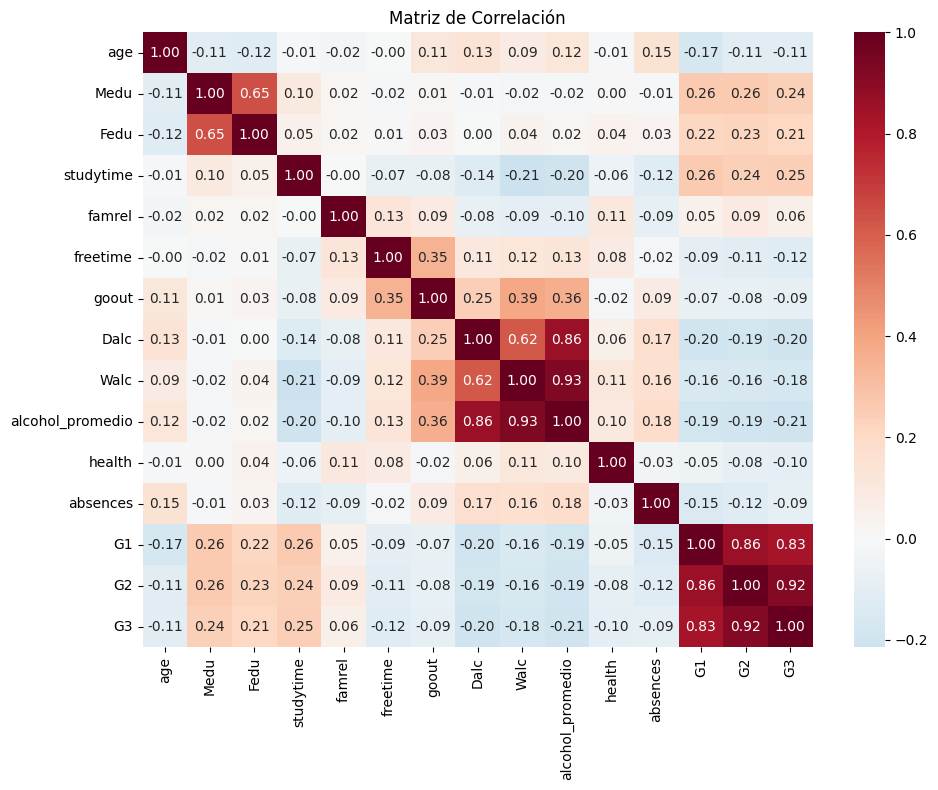


Correlaciones más significativas:
Variable 1       Variable 2  Correlacion
      Walc alcohol_promedio     0.930831
        G2               G3     0.918548
        G1               G2     0.864982
      Dalc alcohol_promedio     0.861636
        G1               G3     0.826387
      Medu             Fedu     0.647477
      Dalc             Walc     0.616561
     goout             Walc     0.388680
     goout alcohol_promedio     0.364339
  freetime            goout     0.346352


In [44]:
print("CORRELACIÓN DE PEARSON")

variables = [
    'age', 'Medu', 'Fedu',
    'studytime', 'famrel', 'freetime', 'goout',
    'Dalc', 'Walc', 'alcohol_promedio',
    'health', 'absences',
    'G1', 'G2', 'G3']

corr = df[variables].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

#Máscara para no repetir pares (A,B) y (B,A)
mascara = np.triu(np.ones_like(corr, dtype=bool))
triangulo_inf = corr.mask(mascara)

corr_lista = triangulo_inf.unstack().dropna().reset_index()
corr_lista.columns = ['Variable 1', 'Variable 2', 'Correlacion']

corr_lista['Fuerza'] = corr_lista['Correlacion'].abs()

top_corr = corr_lista.sort_values(by='Fuerza', ascending=False).head(10)

print("\nCorrelaciones más significativas:")
print(top_corr[['Variable 1', 'Variable 2', 'Correlacion']].to_string(index=False))

ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

Varianza explicada por componente:
  PC1: 24.81% (Acumulada: 24.81%)
  PC2: 16.15% (Acumulada: 40.95%)
  PC3: 9.32% (Acumulada: 50.27%)
  PC4: 8.87% (Acumulada: 59.15%)
  PC5: 7.25% (Acumulada: 66.40%)


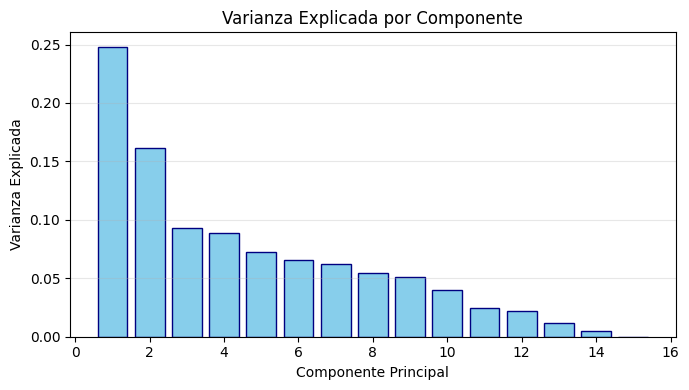

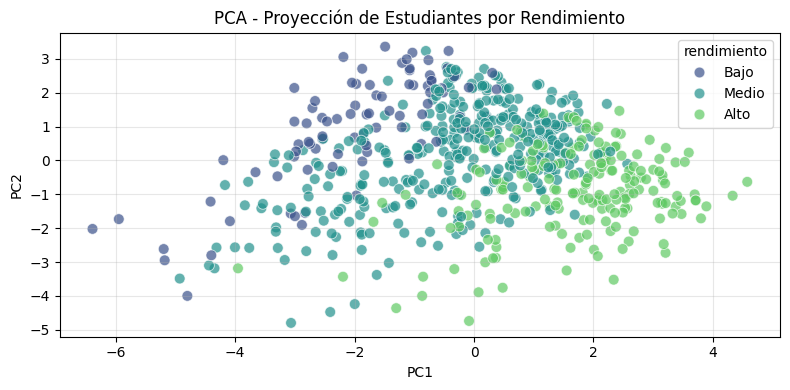


Variables importantes (|carga| >= 0.3):

PC1:
  Dalc: -0.330
  Walc: -0.338
  alcohol_promedio: -0.371
  G1: 0.387
  G2: 0.396
  G3: 0.394

PC2:
  Medu: -0.302
  Fedu: -0.311
  Dalc: -0.342
  Walc: -0.392
  alcohol_promedio: -0.411
  G1: -0.313
  G2: -0.324
  G3: -0.307


In [45]:
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")

scaler = StandardScaler()
scaled = scaler.fit_transform(df[variables])

Xc = scaled - np.mean(scaled, axis=0)
C = Xc.T @ Xc
eigenvalores, eigenvectores = np.linalg.eigh(C)

idx = np.argsort(eigenvalores)[::-1]
eigenvalores = eigenvalores[idx]
eigenvectores = eigenvectores[:, idx]

var_explicada = eigenvalores / eigenvalores.sum()
var_acumulada = np.cumsum(var_explicada)

print(f"\nVarianza explicada por componente:")
for i in range(min(5, len(var_explicada))):
    print(f"  PC{i+1}: {var_explicada[i]*100:.2f}% (Acumulada: {var_acumulada[i]*100:.2f}%)")

plt.figure(figsize=(7, 4))
plt.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue', edgecolor='navy')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

V2 = eigenvectores[:, :2]
pca_res = Xc @ V2

cargas = pd.DataFrame(V2, index=variables, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 4))
sns.scatterplot(x=pca_res[:, 0], y=pca_res[:, 1], hue=df['rendimiento'],
    palette='viridis', alpha=0.7, s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Proyección de Estudiantes por Rendimiento')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Variables más importantes
umbral = 0.3
print(f"\nVariables importantes (|carga| >= {umbral}):")
print("\nPC1:")
importantes_pc1 = cargas.index[cargas['PC1'].abs() >= umbral]
for var in importantes_pc1:
    print(f"  {var}: {cargas.loc[var, 'PC1']:.3f}")

print("\nPC2:")
importantes_pc2 = cargas.index[cargas['PC2'].abs() >= umbral]
for var in importantes_pc2:
    print(f"  {var}: {cargas.loc[var, 'PC2']:.3f}")

ESCALAMIENTO MULTIDIMENSIONAL (MDS)

Matriz de distancias: (649, 649)
Stress final: 482761.8704

Muestra de la Matriz de Distancias:


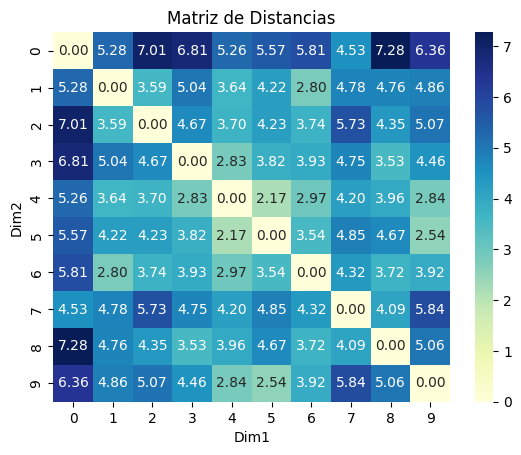

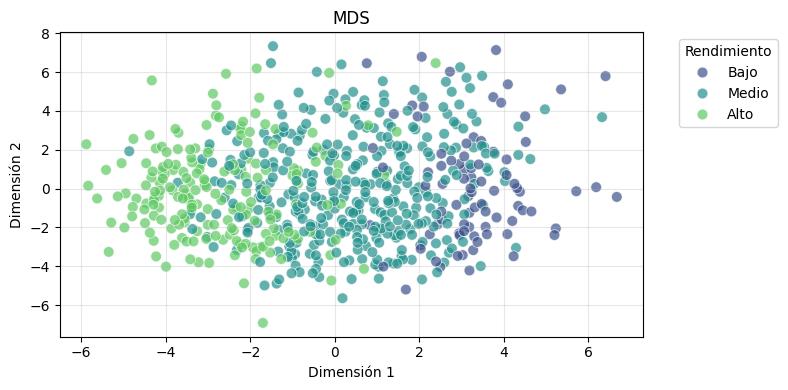

In [48]:
print("ESCALAMIENTO MULTIDIMENSIONAL (MDS)")

D = pairwise_distances(scaled)
print(f"\nMatriz de distancias: {D.shape}")

mds = MDS(n_components=2, dissimilarity='precomputed',
          random_state=42, normalized_stress='auto')
mds_res = mds.fit_transform(D)

print(f"Stress final: {mds.stress_:.4f}")

dist_sample = pd.DataFrame(D[:10, :10])
print("\nMuestra de la Matriz de Distancias:")
sns.heatmap(D[:10, :10], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Matriz de Distancias")
plt.xlabel("Dim1")
plt.ylabel("Dim2")
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(x=mds_res[:, 0], y=mds_res[:, 1], hue=df['rendimiento'],
                palette='viridis', alpha=0.7, s=60)
plt.title(f"MDS")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(alpha=0.3)
plt.legend(title='Rendimiento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
df.to_csv('student_por_preprocesado.csv', index=False)
print(f"\nDataset procesado guardado: student_por_preprocesado.csv")


Dataset procesado guardado: student_por_preprocesado.csv
